In [275]:
import pandas as pd 
import urllib
import matplotlib.pyplot as plt
from matplotlib import dates, colors
import numpy as np 
from matplotlib import dates
from scipy.io import readsav
from sunpy.net import Fido, attrs as a
from astropy.time import Time, TimeDelta
import astrospice
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames
from astropy import units as u

## Fermi/GBM flare list

In [8]:
def get_fermi_flare_list():
    url = "https://hesperia.gsfc.nasa.gov/fermi/gbm/qlook/fermi_gbm_flare_list.txt"
    urllib.request.urlretrieve(url, url.split("/")[-1])

In [9]:
fermi_flares = pd.read_csv("fermi_gbm_flare_list.txt", skiprows=8, skipfooter=35, 
                 encoding = "ISO-8859-1", delim_whitespace=True, engine="python",
                 usecols=[0,1,2,3,4,5,6, 7, 8, 9, 10, 11], 
                 names=["flare", "date", "ts", "tp", "te", "dur", "peak counts", 
                        "total_counts", "sun_det0", "sun_det1", "sun_det2", "sun_det3"])

In [10]:
fermi_flares["t_start"] = pd.to_datetime(fermi_flares["date"] + fermi_flares["ts"], format="%d-%b-%Y%H:%M:%S")
fermi_flares["t_peak"] = pd.to_datetime(fermi_flares["date"] + fermi_flares["tp"], format="%d-%b-%Y%H:%M:%S")
fermi_flares["t_end"] = pd.to_datetime(fermi_flares["date"] + fermi_flares["te"], format="%d-%b-%Y%H:%M:%S")

In [11]:
fermi_flares.drop(columns=["ts", "tp", "te"], inplace=True)

In [210]:
fermi_flares.head(3)

,flare,date,dur,peak counts,total_counts,sun_det0,sun_det1,sun_det2,sun_det3,t_start,t_peak,t_end,unique_month
0,081211_1142,11-Dec-2008,197,2408,90103,n5,n1,n3,n4,2008-12-11 11:42:14,2008-12-11 11:42:51,2008-12-11 11:45:31,2008-12
1,090706_1702,6-Jul-2009,139,2434,45224,n5,n1,n3,n4,2009-07-06 17:02:53,2009-07-06 17:03:10,2009-07-06 17:05:13,2009-07
2,091025_0216,25-Oct-2009,1114,3859,553653,n5,n1,n3,n4,2009-10-25 02:16:59,2009-10-25 02:21:29,2009-10-25 02:35:33,2009-10


In [12]:
new_fermi_flares = fermi_flares[fermi_flares["t_start"] > "2021-01-01"]
new_fermi_flares.reset_index(inplace=True, drop=True)

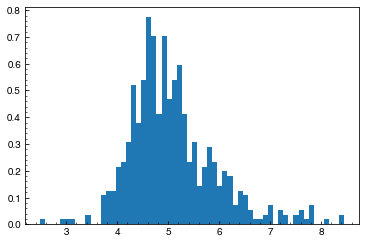

In [15]:
_ = plt.hist(np.log10(new_fermi_flares["total_counts"].values), bins=60, density=True)

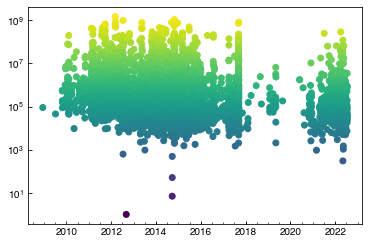

In [16]:
plt.scatter(fermi_flares["t_peak"], fermi_flares["total_counts"], c=fermi_flares["total_counts"], 
            norm=colors.LogNorm())
plt.yscale("log")

In [17]:
fermi_flares["unique_month"] = fermi_flares["t_peak"].dt.strftime("%Y-%m")

Text(0.5, 0, 'Time')

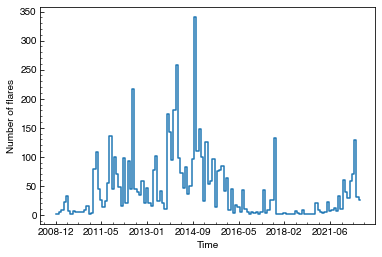

In [18]:
fig, ax = plt.subplots()
fermi_flares.groupby("unique_month").count()["flare"].plot(drawstyle="steps-mid")
ax.set_ylabel("Number of flares")
ax.set_xlabel("Time")

## GOES flare list

In [111]:
# res = Fido.search(a.Time("2021-01-01", "2022-07-18"), 
#                   a.hek.EventType("FL"),
#                   a.hek.FL.GOESCls >= "C1.0")

In [112]:
# new_table = res["hek"]["event_starttime", "event_peaktime",
#                         "event_endtime", "fl_goescls", "ar_noaanum", 'hpc_x', 'hpc_y', "frm_name"]
# new_table2 = new_table[new_table["frm_name"]=="SWPC"]
# new_table2.to_pandas().to_csv("goes_flares_20210101_20220718.csv", index_label=False)

In [129]:
hek_flares = pd.read_csv("goes_flares_20210101_20220718.csv")
swpc_flares = pd.read_csv("swpc_flarelist_20100101-20220717_concat.csv")

In [176]:
hek_flares["tstart_dt"] = pd.to_datetime(hek_flares["event_starttime"])

In [178]:
def get_goes_class(x):
    if x[0]=="C":
        return float(x[1:])*1e-6
    elif x[0] == "M":
        return float(x[1:])*(1e-5)
    elif x[0] == "X":
        return float(x[1:])*(1e-4)
    elif x[0] == "B":
        return float(x[1:])*(1e-7)
    elif x[0] == "A":
        return float(x[1:])*(1e-8)
    else:
        return



In [179]:
hek_flares["goes_flux"] = hek_flares["fl_goescls"].map(get_goes_class)

In [225]:
swpc_flares["goes_class_ind"].unique()

array(['C', 'M', 'X'], dtype=object)

In [136]:
swpc_flares["tstart_dt"] = pd.to_datetime(swpc_flares["ts"], format="%Y%m%d%H%M%S")
swpc_flares["unique_month"] = swpc_flares.tstart_dt.dt.strftime("%Y-%m")
swpc_flares_new = swp

In [138]:
swpc_flares.groupby("unique_month").count()["goes_class_ind"]

unique_month
2010-01     34
2010-02     53
2010-03      9
2010-04      1
2010-05      9
          ... 
2022-03    150
2022-04    224
2022-05    256
2022-06    107
2022-07    119
Name: goes_class_ind, Length: 127, dtype: int64

<IPython.core.display.Javascript object>


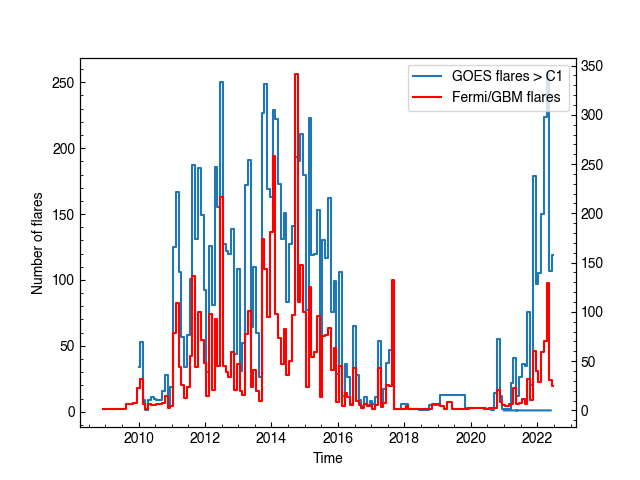

In [149]:
fig, ax = plt.subplots()
plt.plot(pd.to_datetime(swpc_flares.groupby("unique_month").count().index), 
         swpc_flares.groupby("unique_month").count()["goes_class_ind"],
         drawstyle="steps-mid", label="GOES flares > C1")
plt.plot(np.nan, color='r', label="Fermi/GBM flares")
ax2 = ax.twinx()
ax2.plot(pd.to_datetime(fermi_flares.groupby("unique_month").count().index), 
         fermi_flares.groupby("unique_month").count()["flare"],
         drawstyle="steps-mid", color='r')
ax.set_ylabel("Number of flares")
ax.set_xlabel("Time")
ax.legend()


## STIX flares

In [151]:
from stixdcpy.net import JSONRequest as jreq

In [157]:
flares=jreq.fetch_flare_list('2021-01-01T00:00:00', '2021-12-31T00:00:00', sort='goes')
flares2=jreq.fetch_flare_list('2022-01-01T00:00:00', '2022-06-01T00:00:00', sort='goes')

In [158]:
df1 = pd.DataFrame(flares)
df2 = pd.DataFrame(flares2)

In [159]:
stix_flares = pd.concat([df1, df2])

In [161]:
stix_flares["start_UTC"] = pd.to_datetime(stix_flares["start_UTC"])

In [163]:
stix_flares.sort_values(by="start_UTC", inplace=True)

In [164]:
stix_flares.reset_index(drop=True, inplace=True)

In [189]:
stix_flares["goes_class_ind"] = [x[0] for x in stix_flares["GOES_class"]]
stix_flares_c = stix_flares[stix_flares["goes_class_ind"].isin(["X", "M", "C"])]

<IPython.core.display.Javascript object>


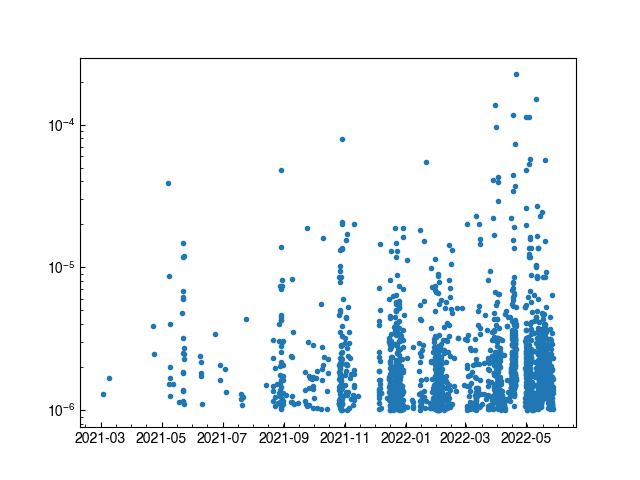

In [190]:
fig, ax = plt.subplots()
plt.plot(stix_flares_c.start_UTC, stix_flares_c.GOES_flux, marker='.', ls='')#="steps-mid")
#plt.plot(hek_flares["tstart_dt"], hek_flares["goes_flux"], marker='.', ls='')
plt.yscale("log")

In [191]:
stix_flares_c.reset_index(drop=True, inplace=True)

In [192]:
stix_flares_c

,flare_id,duration,peak_UTC,LC0_BKG,_id,GOES_class,GOES_flux,CFL_X_arcsec,CFL_Y_arcsec,start_UTC,end_UTC,LC0_peak_counts_4sec,goes_class_ind
0,2103022359,200,2021-03-02T23:59:23.152,271.0,353,C1.3,0.000001,-2000.0,-2000.0,2021-03-02 23:58:03.152,2021-03-03T00:01:23.152,12799,C
1,2103091231,844,2021-03-09T12:31:35.314,271.0,457,C1.7,0.000002,-2000.0,-2000.0,2021-03-09 12:22:03.313,2021-03-09T12:36:07.315,4351,C
2,2104220449,4556,2021-04-22T04:49:28.943,247.0,586,C3.9,0.000004,0.0,0.0,2021-04-22 04:17:05.039,2021-04-22T05:33:00.947,2687,C
3,2104232311,532,2021-04-23T23:11:23.798,247.0,587,C2.5,0.000002,1060.0,-520.0,2021-04-23 23:09:07.798,2021-04-23T23:17:59.799,799,C
4,2105071900,1668,2021-05-07T19:00:15.200,247.0,706,M3.9,0.000039,540.0,270.0,2021-05-07 18:51:07.200,2021-05-07T19:18:55.202,311295,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2050,2205271156,1080,2022-05-27T11:56:44.300,271.0,7520,C1.7,0.000002,None,None,2022-05-27 11:51:28.300,2022-05-27T12:09:28.302,1471,C
2051,2205271540,136,2022-05-27T15:40:56.323,247.0,7525,C1.4,0.000001,None,None,2022-05-27 15:40:16.323,2022-05-27T15:42:32.323,335,C
2052,2205271629,80,2022-05-27T16:29:52.328,247.0,7526,C1.0,0.000001,None,None,2022-05-27 16:29:12.328,2022-05-27T16:30:32.328,399,C
2053,2205271922,900,2022-05-27T19:22:56.346,247.0,7551,C1.5,0.000001,None,None,2022-05-27 19:16:48.346,2022-05-27T19:31:48.347,543,C


<IPython.core.display.Javascript object>


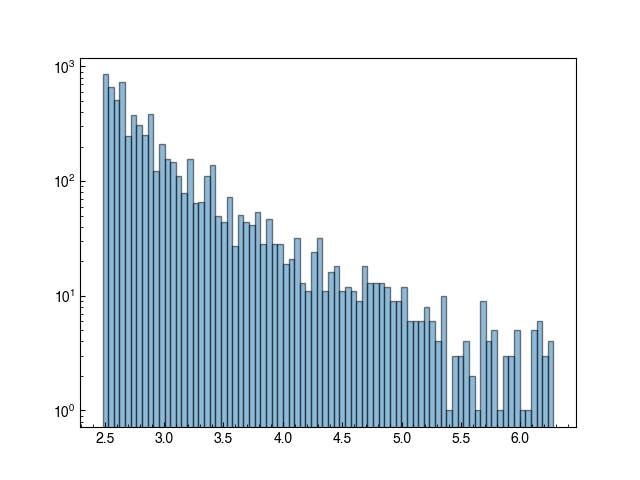

In [224]:
fig, ax = plt.subplots()
ax.hist(np.log10(stix_flares["LC0_peak_counts_4sec"]), bins=80, edgecolor='k', alpha=0.5)
# ax2 = ax.twinx()
# ax2.hist(np.log10(new_fermi_flares["peak counts"]), bins=100, edgecolor='k', alpha=0.5, color='r')
ax.set_yscale("log")

ax2.set_yscale("log")

In [229]:
stix_flares.head()

,flare_id,duration,peak_UTC,LC0_BKG,_id,GOES_class,GOES_flux,CFL_X_arcsec,CFL_Y_arcsec,start_UTC,end_UTC,LC0_peak_counts_4sec,goes_class_ind
0,2101010439,380,2021-01-01T04:39:50.116,247.0,284,B2.1,2.118954e-07,0.0,0.0,2021-01-01 04:38:38.116,2021-01-01T04:44:58.116,463,B
1,2101011501,344,2021-01-01T15:01:26.174,247.0,285,B1.9,1.905123e-07,NaN,NaN,2021-01-01 14:58:34.174,2021-01-01T15:04:18.174,431,B
2,2101061410,228,2021-01-06T14:10:46.745,247.0,286,A,1.325816e-08,-2000.0,-2000.0,2021-01-06 14:09:38.745,2021-01-06T14:13:26.745,671,A
3,2101061852,1256,2021-01-06T18:52:46.771,247.0,287,A,8.219171e-09,NaN,NaN,2021-01-06 18:46:50.771,2021-01-06T19:07:46.773,303,A
4,2101090601,2884,2021-01-09T06:01:22.804,247.0,288,A,1.780953e-08,0.0,0.0,2021-01-09 05:32:30.802,2021-01-09T06:20:34.806,335,A


In [228]:
new_fermi_flares.head(3)

,flare,date,dur,peak counts,total_counts,sun_det0,sun_det1,sun_det2,sun_det3,t_start,t_peak,t_end
0,210115_2358,15-Jan-2021,106,555,12977,n5,n3,n1,n4,2021-01-15 23:58:34,2021-01-15 00:00:12,2021-01-15 00:00:21
1,210116_2358,16-Jan-2021,106,543,13410,n1,n3,n0,n5,2021-01-16 23:58:32,2021-01-16 23:59:50,2021-01-16 00:00:18
2,210117_2358,17-Jan-2021,106,811,20519,n5,n3,n1,n0,2021-01-17 23:58:34,2021-01-17 23:58:38,2021-01-17 00:00:20


In [230]:
from sunpy.time import TimeRange

In [232]:
timerange = TimeRange("2020-01-01", "2022-01-01")

In [233]:
"2021-01-01" in timerange

True

## Match flarelists

In [402]:
fermi_flares_int = fermi_flares[(fermi_flares["t_start"]>="2021-01-01")&(fermi_flares["t_start"]<="2022-06-01")]
fermi_flares_int.reset_index(inplace=True, drop=True)
#fermi_flares_int.to_csv("fermi_flares_20210101_20220601.csv", index_label=False)

hek_flares_int= hek_flares[(hek_flares["tstart_dt"]>="2021-01-01")&(hek_flares["tstart_dt"]<="2022-06-01")]
hek_flares_int.reset_index(inplace=True, drop=True)
#hek_flares.to_csv("goes_hek_flares_20210101_20220601.csv", index_label=False)

stix_flares_int = stix_flares_c[(stix_flares_c["start_UTC"]>="2021-01-01")&(stix_flares_c["start_UTC"]<="2022-06-01")]
stix_flares_int.reset_index(inplace=True, drop=True)

## STIX flares as a function of position

In [288]:
kernals = astrospice.registry.get_kernels("solar orbiter", "predict")

/Users/laura.hayes/opt/miniconda3/envs/stix_directivity/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [ ]:
tstart = Time("2021-01-01T00:00:00.000")
tend = Time("2022-06-01T00:00:00.000")
times = Time(np.arange(tstart, tend, TimeDelta(1*u.day)))

In [296]:
solo_coords = astrospice.generate_coords("SOLAR ORBITER", times)
earth_coords = astrospice.generate_coords("earth", times)
sun_coords = astrospice.generate_coords("sun", times)

solo_coords_hgs = solo_coords.transform_to(frames.HeliographicStonyhurst)
earth_coords_hgs = earth_coords.transform_to(frames.HeliographicStonyhurst)
sun_coords_hgs = sun_coords.transform_to(frames.HeliographicStonyhurst)

In [297]:
solo_flare_coords = astrospice.generate_coords("SOLAR ORBITER", Time(stix_flares_int["start_UTC"]))
solo_flare_coords_hgs = solo_flare_coords.transform_to(frames.HeliographicStonyhurst)

In [298]:
solo_flare_coords_hgs

<SkyCoord (HeliographicStonyhurst: obstime=['2021-03-02T23:58:03.152000000' '2021-03-09T12:22:03.313000000'
 '2021-04-22T04:17:05.039000000' ... '2022-05-27T16:29:12.328000000'
 '2022-05-27T19:16:48.346000000' '2022-05-28T01:27:16.383000000'], rsun=695700.0 km): (lon, lat, radius) in (deg, deg, km)
    [(-127.9807996 , 2.00419873, 8.44448701e+07),
     (-119.36748409, 1.88521104, 9.05619094e+07),
     ( -97.89092262, 0.16413925, 1.29168720e+08), ...,
     ( 164.83857054, 2.32185905, 1.35749270e+08),
     ( 164.82494553, 2.31563693, 1.35850375e+08),
     ( 164.79433192, 2.30189259, 1.36072670e+08)]>

In [299]:
ticks = dates.date2num(times.datetime)

In [310]:
%matplotlib inline

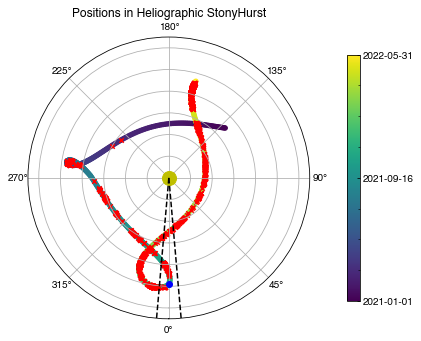

In [335]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='polar')

im = ax.scatter(solo_coords_hgs.lon.to(u.rad), 
           solo_coords_hgs.radius.to(u.au), c=ticks, s=20)

ax.plot(earth_coords_hgs[0].lon.to(u.rad), 
           earth_coords_hgs[0].radius.to(u.au), ms=12, marker='.', color="blue", label="Earth")

ax.plot(sun_coords_hgs[0].lon.to(u.rad), 
        sun_coords_hgs[0].radius.to(u.AU), marker='o', color='y', label="Sun",  ms=14)


ax.scatter(solo_flare_coords_hgs.lon.to(u.rad), 
           solo_flare_coords_hgs.radius.to(u.au), s=20, marker='x', color='r', label="Flares")

ax.plot([0*u.deg.to(u.rad), 5*u.deg.to(u.rad)], [0, 1.3], color='k', ls="dashed")
ax.plot([0*u.deg.to(u.rad), -5*u.deg.to(u.rad)], [0, 1.3], color='k', ls="dashed")

ax.set_theta_zero_location("S")
_ = ax.set_yticklabels([])

ax.set_rlim(0, 1.3)
ax.set_title("Positions in Heliographic StonyHurst")

cbar = fig.colorbar(im, ticks=[ticks[0],ticks[int(len(ticks)/2)], ticks[-1]], pad=0.1, shrink=0.6)
cbar.ax.set_yticklabels([dates.num2date(ticks[0]).strftime("%Y-%m-%d"), 
                         dates.num2date(ticks[int(len(ticks)/2)]).strftime("%Y-%m-%d"),
                         dates.num2date(ticks[-1]).strftime("%Y-%m-%d")])  # vertically oriented colorbar
#ax.legend()
plt.tight_layout()
plt.savefig("orbit_from_earth.png", dpi=300, facecolor='w', bbox_inches="tight")

In [306]:
stix_flares_c["loc"] = solo_flare_coords_hgs

/var/folders/wm/gysdzbp10qv1kcm4zxb5q95xkjzv5q/T/ipykernel_92017/676685316.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stix_flares_c["loc"] = solo_flare_coords_hgs


In [344]:
solo_flare_coords_hgs.lon.value

array([-127.9807996 , -119.36748409,  -97.89092262, ...,  164.83857054,
        164.82494553,  164.79433192])

In [364]:
stix_flares_c["lon"] = solo_flare_coords_hgs.lon.value
stix_flares_c["rad"] = solo_flare_coords_hgs.radius.value

/var/folders/wm/gysdzbp10qv1kcm4zxb5q95xkjzv5q/T/ipykernel_92017/777418820.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stix_flares_c["lon"] = solo_flare_coords_hgs.lon.value
/var/folders/wm/gysdzbp10qv1kcm4zxb5q95xkjzv5q/T/ipykernel_92017/777418820.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stix_flares_c["rad"] = solo_flare_coords_hgs.radius.value


In [392]:
stix_flares_c.head(3)

,flare_id,duration,peak_UTC,LC0_BKG,_id,GOES_class,GOES_flux,CFL_X_arcsec,CFL_Y_arcsec,start_UTC,end_UTC,LC0_peak_counts_4sec,goes_class_ind,loc,lon,rad
0,2103022359,200,2021-03-02T23:59:23.152,271.0,353,C1.3,0.000001,-2000.0,-2000.0,2021-03-02 23:58:03.152,2021-03-03T00:01:23.152,12799,C,<SkyCoord (HeliographicStonyhurst: obstime=202...,-127.980800,8.444487e+07
1,2103091231,844,2021-03-09T12:31:35.314,271.0,457,C1.7,0.000002,-2000.0,-2000.0,2021-03-09 12:22:03.313,2021-03-09T12:36:07.315,4351,C,<SkyCoord (HeliographicStonyhurst: obstime=202...,-119.367484,9.056191e+07
2,2104220449,4556,2021-04-22T04:49:28.943,247.0,586,C3.9,0.000004,0.0,0.0,2021-04-22 04:17:05.039,2021-04-22T05:33:00.947,2687,C,<SkyCoord (HeliographicStonyhurst: obstime=202...,-97.890923,1.291687e+08


In [393]:
stix_flares_c.keys()

Index(['flare_id', 'duration', 'peak_UTC', 'LC0_BKG', '_id', 'GOES_class',
       'GOES_flux', 'CFL_X_arcsec', 'CFL_Y_arcsec', 'start_UTC', 'end_UTC',
       'LC0_peak_counts_4sec', 'goes_class_ind', 'loc', 'lon', 'rad'],
      dtype='object')

In [394]:
columns_of_interest = ["start_UTC", "peak_UTC", "end_UTC", "duration", "GOES_flux", 
                       "GOES_class", "LC0_peak_counts_4sec", "lon", "rad"]

In [395]:
stix_save_flares = stix_flares_c[columns_of_interest]

In [396]:
stix_save_flares.head(3)

,start_UTC,peak_UTC,end_UTC,duration,GOES_flux,GOES_class,LC0_peak_counts_4sec,lon,rad
0,2021-03-02 23:58:03.152,2021-03-02T23:59:23.152,2021-03-03T00:01:23.152,200,0.000001,C1.3,12799,-127.980800,8.444487e+07
1,2021-03-09 12:22:03.313,2021-03-09T12:31:35.314,2021-03-09T12:36:07.315,844,0.000002,C1.7,4351,-119.367484,9.056191e+07
2,2021-04-22 04:17:05.039,2021-04-22T04:49:28.943,2021-04-22T05:33:00.947,4556,0.000004,C3.9,2687,-97.890923,1.291687e+08


In [398]:
# stix_save_flares.to_csv("stix_flares_c_with_loc.csv", index_label=False)

In [366]:
stix_5deg = stix_flares_c[(stix_flares_c["lon"]<=5)&(stix_flares_c["lon"]>=-5)]

In [367]:
coords_5deg = solo_flare_coords_hgs[(stix_flares_c["lon"]<=5)&(stix_flares_c["lon"]>=-5)]

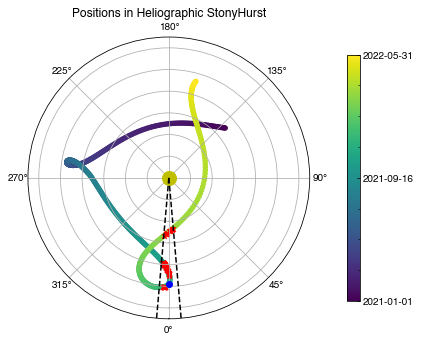

In [371]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='polar')

im = ax.scatter(solo_coords_hgs.lon.to(u.rad), 
           solo_coords_hgs.radius.to(u.au), c=ticks, s=20)

ax.plot(earth_coords_hgs[0].lon.to(u.rad), 
           earth_coords_hgs[0].radius.to(u.au), ms=12, marker='.', color="blue", label="Earth")

ax.plot(sun_coords_hgs[0].lon.to(u.rad), 
        sun_coords_hgs[0].radius.to(u.AU), marker='o', color='y', label="Sun",  ms=14)



ax.scatter(stix_5deg["lon"]*u.deg.to(u.rad), 
           stix_5deg["rad"]*u.km.to(u.au), s=20, marker='x', color='r', label="Flares")


ax.plot([0*u.deg.to(u.rad), 5*u.deg.to(u.rad)], [0, 1.3], color='k', ls="dashed")
ax.plot([0*u.deg.to(u.rad), -5*u.deg.to(u.rad)], [0, 1.3], color='k', ls="dashed")

ax.set_theta_zero_location("S")
_ = ax.set_yticklabels([])

ax.set_rlim(0, 1.3)
ax.set_title("Positions in Heliographic StonyHurst")

cbar = fig.colorbar(im, ticks=[ticks[0],ticks[int(len(ticks)/2)], ticks[-1]], pad=0.1, shrink=0.6)
cbar.ax.set_yticklabels([dates.num2date(ticks[0]).strftime("%Y-%m-%d"), 
                         dates.num2date(ticks[int(len(ticks)/2)]).strftime("%Y-%m-%d"),
                         dates.num2date(ticks[-1]).strftime("%Y-%m-%d")])  # vertically oriented colorbar
#ax.legend()
plt.tight_layout()
plt.savefig("orbit_from_earth_within5.png", dpi=300, facecolor='w', bbox_inches="tight")

In [379]:
stix_5deg_m = stix_5deg[stix_5deg["goes_class_ind"].isin(["M"])]

In [380]:
stix_5deg_m

,flare_id,duration,peak_UTC,LC0_BKG,_id,GOES_class,GOES_flux,CFL_X_arcsec,CFL_Y_arcsec,start_UTC,end_UTC,LC0_peak_counts_4sec,goes_class_ind,loc,lon,rad
160,2110260246,376,2021-10-26T02:46:35.577,247.0,2537,M1.3,0.000013,0.0,0.0,2021-10-26 02:44:51.577,2021-10-26T02:51:07.578,172031,M,<SkyCoord (HeliographicStonyhurst: obstime=202...,-3.798244,1.177350e+08
182,2110261554,376,2021-10-26T15:54:47.660,271.0,2614,M1.0,0.000010,0.0,0.0,2021-10-26 15:51:43.660,2021-10-26T15:57:59.661,86015,M,<SkyCoord (HeliographicStonyhurst: obstime=202...,-3.573378,1.182816e+08
211,2110280739,508,2021-10-28T07:39:39.400,271.0,2601,M1.3,0.000013,290.0,-670.0,2021-10-28 07:38:39.400,2021-10-28T07:47:07.401,155647,M,<SkyCoord (HeliographicStonyhurst: obstime=202...,-2.934817,1.199389e+08
214,2110281030,536,2021-10-28T10:30:15.418,735.0,2650,M2.1,0.000021,330.0,-640.0,2021-10-28 10:27:27.418,2021-10-28T10:36:23.419,221183,M,<SkyCoord (HeliographicStonyhurst: obstime=202...,-2.892091,1.200560e+08
224,2110281526,144,2021-10-28T15:26:15.448,735.0,2656,M2.0,0.000020,320.0,-570.0,2021-10-28 15:24:47.448,2021-10-28T15:27:11.448,155647,M,<SkyCoord (HeliographicStonyhurst: obstime=202...,-2.817601,1.202622e+08
225,2110281540,220,2021-10-28T15:40:07.449,735.0,2657,M7.9,0.000079,320.0,-550.0,2021-10-28 15:37:27.449,2021-10-28T15:41:07.450,344063,M,<SkyCoord (HeliographicStonyhurst: obstime=202...,-2.814449,1.202710e+08
226,2110281736,35680,2021-10-28T17:36:11.461,735.0,2658,M1.4,0.000014,20.0,0.0,2021-10-28 16:12:07.453,2021-10-29T02:06:47.513,1855,M,<SkyCoord (HeliographicStonyhurst: obstime=202...,-2.805832,1.202951e+08
235,2111010137,2236,2021-11-01T01:37:12.050,271.0,2695,M1.6,0.000016,0.0,0.0,2021-11-01 01:26:04.049,2021-11-01T02:03:20.053,63487,M,<SkyCoord (HeliographicStonyhurst: obstime=202...,-1.722564,1.236649e+08
242,2111020242,6240,2021-11-02T02:42:22.803,271.0,2708,M1.7,0.000017,0.0,0.0,2021-11-02 02:12:58.800,2021-11-02T03:56:58.811,47103,M,<SkyCoord (HeliographicStonyhurst: obstime=202...,-1.440809,1.246871e+08
260,2111091653,3160,2021-11-09T16:53:03.716,247.0,2795,M2.0,0.000020,0.0,0.0,2021-11-09 16:37:31.714,2021-11-09T17:30:11.720,55295,M,<SkyCoord (HeliographicStonyhurst: obstime=202...,0.004987,1.320723e+08


In [390]:
stix_90deg = stix_flares_c[((stix_flares_c["lon"]<=90)&(stix_flares_c["lon"]>=20))|
                           ((stix_flares_c["lon"]>=-90)&(stix_flares_c["lon"]<=-20))]

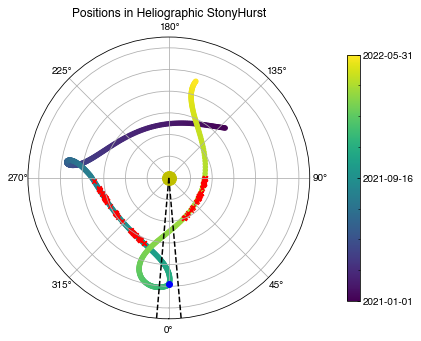

In [391]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='polar')

im = ax.scatter(solo_coords_hgs.lon.to(u.rad), 
           solo_coords_hgs.radius.to(u.au), c=ticks, s=20)

ax.plot(earth_coords_hgs[0].lon.to(u.rad), 
           earth_coords_hgs[0].radius.to(u.au), ms=12, marker='.', color="blue", label="Earth")

ax.plot(sun_coords_hgs[0].lon.to(u.rad), 
        sun_coords_hgs[0].radius.to(u.AU), marker='o', color='y', label="Sun",  ms=14)



ax.scatter(stix_90deg["lon"]*u.deg.to(u.rad), 
           stix_90deg["rad"]*u.km.to(u.au), s=20, marker='x', color='r', label="Flares")


ax.plot([0*u.deg.to(u.rad), 5*u.deg.to(u.rad)], [0, 1.3], color='k', ls="dashed")
ax.plot([0*u.deg.to(u.rad), -5*u.deg.to(u.rad)], [0, 1.3], color='k', ls="dashed")

ax.set_theta_zero_location("S")
_ = ax.set_yticklabels([])

ax.set_rlim(0, 1.3)
ax.set_title("Positions in Heliographic StonyHurst")

cbar = fig.colorbar(im, ticks=[ticks[0],ticks[int(len(ticks)/2)], ticks[-1]], pad=0.1, shrink=0.6)
cbar.ax.set_yticklabels([dates.num2date(ticks[0]).strftime("%Y-%m-%d"), 
                         dates.num2date(ticks[int(len(ticks)/2)]).strftime("%Y-%m-%d"),
                         dates.num2date(ticks[-1]).strftime("%Y-%m-%d")])  # vertically oriented colorbar
#ax.legend()
plt.tight_layout()
plt.savefig("orbit_from_earth_within90.png", dpi=300, facecolor='w', bbox_inches="tight")